# Automatic Differentiation

Differentiation is a crucial step in nearly all deep learning optimization algorithms.

Automatic differentiation enables the system to subsequently backpropagate gradients. Here, backpropagate simply means to trace through the computational graph, filling in the partial derivatives with respect to each parameter.

In [1]:
import torch

## A Simple Example

Differentiating the function
$y = 2\mathbf{x}^{\top}\mathbf{x}$
with respect to the column vector $\mathbf{x}$.

In [2]:
x = torch.arange(4.0)
x

tensor([0., 1., 2., 3.])

Before we even calculate the gradient
of $y$ with respect to $\mathbf{x}$,
we will need a place to store it.

In [3]:
x.requires_grad_(True)  # Same as `x = torch.arange(4.0, requires_grad=True)`
x.grad  # The default value is None

Now let us calculate $y$.

In [4]:
y = 2 * torch.dot(x, x)
y

tensor(28., grad_fn=<MulBackward0>)

Since `x` is a vector of length 4,
an inner product of `x` and `x` is performed,
yielding the scalar output that we assign to `y`.
Next, we can automatically calculate the gradient of `y`
with respect to each component of `x`
by calling the function for backpropagation and printing the gradient.

In [5]:
y.backward()
x.grad

tensor([ 0.,  4.,  8., 12.])

The gradient of the function $y = 2\mathbf{x}^{\top}\mathbf{x}$
with respect to $\mathbf{x}$ should be $4\mathbf{x}$.
Let us quickly verify that our desired gradient was calculated correctly.

In [6]:
x.grad == 4 * x

tensor([True, True, True, True])

Now let us clculate another function of `x`.

In [7]:
# PyTorch accumulates the gradient in default, we need to clear the previous
# values
x.grad.zero_()
y = x.sum()
y.backward()
x.grad

tensor([1., 1., 1., 1.])

## Backward for Non-Scalar Variables

In [8]:
# Invoking `backward` on a non-scalar requires passing in a `gradient` argument
# which specifies the gradient of the differentiated function w.r.t `self`.
# In our case, we simply want to sum the partial derivatives, so passing
# in a gradient of ones is appropriate
x.grad.zero_()
y = x * x
# y.backward(torch.ones(len(x))) equivalent to the below
y.sum().backward()
x.grad

tensor([0., 2., 4., 6.])

## Detaching Computation

In [9]:
x.grad.zero_()
y = x * x
u = y.detach()
z = u * x

z.sum().backward()
x.grad == u

tensor([True, True, True, True])

In [10]:
x.grad.zero_()
y.sum().backward()
x.grad == 2 * x

tensor([True, True, True, True])

## Computing the Gradient of Python Control Flow

In [11]:
def f(a):
    b = a * 2
    while b.norm() < 1000:
        b = b * 2
    if b.sum() > 0:
        c = b
    else:
        c = 100 * b
    return c

Let us compute the gradient.

In [12]:
a = torch.randn(size=(), requires_grad=True)
d = f(a)
d.backward()

In [13]:
a.grad == d / a

tensor(True)

## Summary

* Deep learning frameworks can automate the calculation of derivatives. To use it, we first attach gradients to those variables with respect to which we desire partial derivatives. We then record the computation of our target value, execute its function for backpropagation, and access the resulting gradient.

## Exercises

1. Why is the second derivative much more expensive to compute than the first derivative?

2. After running the function for backpropagation, immediately run it again and see what happens.

In [14]:
# d.backward()
#  RuntimeError: Trying to backward through the graph a second time, but the saved intermediate results have already been freed. Specify retain_graph=True when calling backward the first time.

In [15]:
x = torch.arange(4.0, requires_grad=True)
y = 2 * torch.dot(x, x)
y.backward(retain_graph=True)
x.grad

tensor([ 0.,  4.,  8., 12.])

In [16]:
y.backward(retain_graph=True)
x.grad

tensor([ 0.,  8., 16., 24.])

3. In the control flow example where we calculate the derivative of `d` with respect to `a`, what would happen if we changed the variable `a` to a random vector or matrix. At this point, the result of the calculation `f(a)` is no longer a scalar. What happens to the result? How do we analyze this?

In [17]:
a = torch.arange(4.0, requires_grad=True)
d = f(a)
# d.backward()
#  RuntimeError: grad can be implicitly created only for scalar outputs
# d.sum().backward()
d.backward(torch.ones_like(a))
a.grad

tensor([512., 512., 512., 512.])

4. Redesign an example of finding the gradient of the control flow. Run and analyze the result.

5. Let $f(x) = \sin(x)$. Plot $f(x)$ and $\frac{df(x)}{dx}$, where the latter is computed without exploiting that $f'(x) = \cos(x)$.

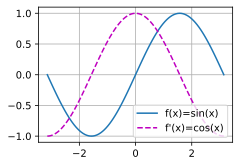

In [18]:
import math
from d2l import torch as d2l

def f(x):
    return torch.sin(x)

x = torch.linspace(-math.pi, math.pi, steps=100, requires_grad=True)
y = f(x)
y.sum().backward()

d2l.plot(x.detach(), (y.detach(), x.grad), legend=(('f(x)=sin(x)',"f'(x)=cos(x)")))